In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
plt.close('all')
import random
import os
import math
from scipy.optimize import curve_fit
from skimage.draw import disk
from tifffile import imsave
from scipy.integrate import quad

In [2]:
def prob(x0,y0,x,y,a,A):
    r=np.sqrt((x-x0)**2+(y-y0)**2)
    if r==0:
        return 1
    else:
        p=A*np.exp(-(r**a))#A/(r**(a))
        #print(p)
        return p
   
    
def makec(p):
    p=int(p*100)
    t=np.random.random_integers(100)
    #print(t,p)
    if p>t:
        return True
    else:
        return False
    
    
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = (r * a + (1.0 - a) * R) /255
    rgb[:,:,1] = (g * a + (1.0 - a) * G) /255
    rgb[:,:,2] = (b * a + (1.0 - a) * B) /255

    return np.asarray( rgb, dtype='uint8' )


def circle(x0,y0,r):
    
    x1=np.linspace(x0-r,x0+r,3000,endpoint=True)
    x2=np.linspace(x0-r,x0+r,3000,endpoint=True)
    y1=np.sqrt(r**2-(x1-x0)**2)+y0
    y2=-1*np.sqrt(r**2-(x1-x0)**2)+y0
    x=np.append(x1,x2)
    y=np.append(y1,y2)
        
    return x,y 

def circletest(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    #print('d',d,r1,r0)
    
    # non intersecting
    if d > r0 + r1 and r0 != r1:
        #print('1')
        return 0
    # One circle within other
    if d < abs(r0-r1):
        #print('2')
        return 1
    # coincident circles
    if d == 0 and r0 == r1:
        #print('3')
        return 0
    else:
        #print('4')
        return 1

    
def splitprob(r,low,high):
    if r <= low:
        diff = 0
    else:
        diff = ((1/(high-low))**3 * (r-low)**3)*100
    return 100-diff

def distance(circle_a, circle_b):
    return ((circle_a.x - circle_b.x) ** 2 + (circle_a.y - circle_b.y) ** 2) ** 0.5
    
def circletest_array(x0, y0, r0):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1
    c_m=np.zeros((len(x0),len(x0)))
    
    
    for i in range(len(x0)):
         for j in range(len(x0)):
                c_m[i,j]=circletest(x0[i], y0[i], r0[i], x0[j], y0[j], r0[j])
    
    #print('sum',np.sum(c_m))
    return np.sum(c_m)
    
def ini_pic(b, r_mu, r_sig, pix_max,pix_min, t, run, path='.',bg=False):
    my_dpi = 96
    
    if not os.path.isdir(path+'/' + str(run)):
        os.mkdir(path+'/' + str(run))
        os.mkdir(path+'/' + str(run) + '_GT')
        os.mkdir(path+'/' + str(run) + '_GT'+'/TRA')
    
    fig = plt.figure(figsize=(pix_max / my_dpi, pix_max / my_dpi), dpi=my_dpi)
    ax = fig.gca()
    
    circles = []
    
    x=np.array([])
    y=np.array([])
    x0c=np.array([2])
    y0c=np.array([0.5])
    rc=np.array([0])
    split_prob=np.array([0])
    
    x_pos = np.linspace(1 * r_mu, 1 - 1 * r_mu, 1500)
    y_pos = np.linspace(1 * r_mu, (pix_min/pix_max) - 1 * r_mu, int((pix_min/pix_max)*1500))
    
    for _ in range(b):
        x0 = np.random.choice(x_pos)
        y0 = np.random.choice(y_pos)
        r_com = np.random.normal(r_mu, r_sig, 1)
        #while r_com < 34/512:
        #    r_com = np.random.normal(r_mu, r_sig, 1)
        circle = Circle(x0, y0, r_com)
        circles.append(circle)
    
    resolve_all_overlaps(circles)
    
    # Extract updated x, y, r values for plotting
    xu, yu, ru = zip(*[(circle.x if isinstance(circle.x, float) else circle.x[0], 
                   circle.y if isinstance(circle.y, float) else circle.y[0], 
                   circle.radius if isinstance(circle.radius, float) else circle.radius[0]) for circle in circles])
    print('xu',xu)
    x0c = np.append(x0c,xu)
    y0c = np.append(y0c,yu)
    rc = np.append(rc,ru)
    
    split_prob = [100 - splitprob(radius, 0.035, 0.06) for radius in rc]
    
    for circle in circles:
        circ = plt.Circle((circle.x, circle.y), circle.radius, color='red', fill=False)
        ax.add_patch(circ)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0, 1)
    plt.ylim(0, (pix_min/pix_max))
    plt.savefig(path+'/'+str(run)+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 
    plt.close()
    
    r_count = np.unique(rc)
    ide = np.append(-1, np.arange(1, b + 1))
    '''
    if len(r_count) < b:
        print('!!!!!!!!!!!!!!!!!', len(r_count))
        x0c, y0c, rc, ide, split_prob = ini_pic(b, r_i, pix, t, run, bg=False)
    '''
    return x0c, y0c, rc, ide, split_prob

def gt(x,y,r,t,run,ide,split_prob,path='.',split_id=0,savefile=True,shuffle=False):
    
    
    #plt.rcParams['axes.facecolor'] = 'black'
    my_dpi=96
    
    #print('r',r,np.mean(r))


    t_v=np.ones(len(x))*t
    
    if t==0:
        split_id=np.zeros(len(x))
    
    if shuffle:
        ind = np.argsort(x) 
        #print('ind',ind)
        random.shuffle(ind)
        #print('ind',ind)
        x=np.array(x)
        y=np.array(y)
        r=np.array(r)
        #print('x',x)
        #print('y',y)
        x= np.take_along_axis(x, ind, axis=-1)  
        #print('x2',x)
        
        y=np.take_along_axis(y, ind, axis=-1) 
        
        #print('y2',y)
        #print('ind2',ind)
        r=np.take_along_axis(r, ind, axis=-1)
        ide=np.take_along_axis(ide, ind, axis=-1)
        split_id=np.take_along_axis(split_id, ind, axis=-1)
        split_prob=np.take_along_axis(split_prob, ind, axis=-1)
    
    
    
    if savefile:
        if t==0:
            np.savetxt(path+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt', np.c_[x,y,r,ide,split_id,split_prob,t_v],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
        else:    
            xl,yl,rl,idel,split_l,s_pr_l,t_vl= np.loadtxt(path+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
            
            xl=np.append(xl,x)
            yl=np.append(yl,y)
            rl=np.append(rl,r)
            t_vl=np.append(t_vl,t_v)
            idel=np.append(idel,ide)
            split_l=np.append(split_l,split_id)
            s_pr_l=np.append(s_pr_l,split_prob)
            np.savetxt(path+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt', np.c_[xl,yl,rl,idel,split_l,s_pr_l,t_vl],delimiter='\t',header='x'+'\t'+'y'+'\t'+'r'+'\t'+'id'+'\t'+'split_id'+'\t'+'s_prob'+'\t'+'t')
    plt.close()

def move(x,y,r,mv_mu,mv_std,sp_prob,t,r_split,pix_max,pix_min,run,ide,path='.',reco=True,forget=True,directed=0):
    
    

    
    vec=np.linspace(0,2*np.pi,500)

    n=pix_max
    my_dpi=96
    fig = plt.figure(figsize=(pix_max/my_dpi, pix_max/my_dpi), dpi=my_dpi)
    
    plt.axis('off')
    
    plt.gca().set_aspect('equal', adjustable='box')
    ax = fig.gca()
    plt.xlim(0,1)
    plt.ylim(0,pix_min/pix_max)
    
    rec_flag=False
    xrec_l=[]
    yrec_l=[]
    rrec_l=[]
    
    for m in range(5):
        
        misdetect=np.random.random_integers(99)
        m_lim=90
    
        if misdetect >= m_lim and reco==True:
            
            coord=np.linspace(0,1,num=500)
            xrec=np.random.choice(coord)
            yrec=np.random.choice(coord)
            rrec=np.random.choice(coord)*10
            #rec=plt.Rectangle((xrec,yrec), rrec*10**(-2), rrec*10**(-2),fc=None,ec="blue") 
            #rec=plt.Circle((xrec,yrec), rrec*10**(-2), color='red',fill=False)
            #ax.add_patch(rec)
            
            xrec_l.append(xrec)
            yrec_l.append(yrec)
            rrec_l.append(rrec)
            
            print('rec!',len(xrec_l))
           
            
            rec_flag=True

    
    #xp=np.array([0,1])
    #yp=np.array([0,1])
    
    pl=True
    
    

        

    re = np.array([])
    x0c=np.array([])
    y0c=np.array([])
    r0c=np.array([])
    idec=np.array([])
    split_id=np.array([])
    split_prob=np.array([])
    flag=0

       
    for i in range(len(x)):
        phi=np.random.choice(vec)
        mv = sample_from_power_law(mv_mu, mv_std, size=1)#rejection_sample(mv_mu, mv_sig)
        x_n=x[i]+(mv/pix_max)*np.sin(phi)
        y_n=y[i]+(mv/pix_max)*np.cos(phi)
        
        
        r_e0=0.1 #!!!!!!!!
        if r[i] < 0.35*r_mu:
            r_e0 = np.random.random_integers(8,12)
            
        re=np.append(re,r_e0)
        #print('ri0',r[i])
        r[i] = r[i]*(1+(r_e0/100))
        #print('ri1',r[i])

        if x_n < 0 or x_n > 1:
            x_n=x[i]-(mv/pix_max)*np.sin(phi)

        if y_n < 0 or y_n > pix_min/pix_max:
            y_n=y[i]-(mv/pix_max)*np.cos(phi)


        sp=np.random.random_integers(99)
        #print('ri',r[i])
        if percent_true(sp_prob) and t>7 and r[i]>r_split and t<10:###splitprob(r[i],0.035,0.06): ###96
            #print(r[i],'split',splitprob(r[i],0.035,0.06))
            flag=flag+1
            d=random.uniform(0.7, 0.8)
            x_n1, y_n1, x_n2, y_n2 = split_cell_axis(x_n, y_n, r[i], d)
            
            
            #x_n1=x_n-1.05*r[i]
            #x_n2=x_n+1.05*r[i]


            #r_e=np.random.random_integers(5)

            #r_n1= r[i]*(1+(r_e/100))
            #r_n2= r[i]*(1-(r_e/100))

            #print('r_n1')
            #r_e1=np.random.random_integers(15,40)
            #r_e2=np.random.random_integers(15,40)
            
            r_e1=np.random.random_integers(40,45)
            

            z=0
            while z<100:


                r_n1= r[i]*(1-(r_e1/100))
                r_n2= r[i]*(1-(r_e1/100))
                #print('r_n1',r_n1)
                #print('r_n2',r_n2)
                if r_n1 in r or r_n2 in r:
                    #print('while',r)
                    r_e1=np.random.random_integers(40,65)
                    #print('r_e',r_e)
                    #r_n1= r[i]*(1+(r_z/100))+r_n1/100
                    #r_n2= r[i]*(1-(r_z/100))+r_n2/100


                    #print()
                    z=z+1
                else:

                    break


            circ1=plt.Circle((x_n1,y_n1), r_n1, color='red',fill=False)
            circ2=plt.Circle((x_n2,y_n2), r_n2, color='red',fill=False)
            ax.add_patch(circ1)
            ax.add_patch(circ2)
            x0c=np.append(x0c,x_n1)
            y0c=np.append(y0c,y_n1)
            x0c=np.append(x0c,x_n2)
            y0c=np.append(y0c,y_n2)

            split_id=np.append(split_id,ide[i])
            split_id=np.append(split_id,ide[i])
            
            split_prob=np.append(split_prob,100-splitprob(r_n1,0.035,0.06))
            split_prob=np.append(split_prob,100-splitprob(r_n2,0.035,0.06))


            if len(idec)!=0:
                max_id=np.max(np.append(ide,idec))
            else:
                max_id=np.max(ide)


            idec=np.append(idec,max_id+1)
            idec=np.append(idec,max_id+2)

            r0c=np.append(r0c,r_n1)
            r0c=np.append(r0c,r_n2)
        else:
            #print(r[i],'nosplit',splitprob(r[i],0.035,0.06))
            split_id=np.append(split_id,0)
            circ=plt.Circle((x_n,y_n), r[i], color='red',fill=False)
            ax.add_patch(circ)
            x0c=np.append(x0c,x_n)
            y0c=np.append(y0c,y_n)
            r0c=np.append(r0c,r[i])
            split_prob=np.append(split_prob,100-splitprob(r[i],0.035,0.06))

            idec=np.append(idec,ide[i])

    circles = [Circle(x, y, r) for x, y, r in zip(x0c, y0c, r0c)]

    # Resolve overlaps
    resolve_all_overlaps(circles)

    # Update your circle lists with new values after resolving overlaps
    x0c = [circle.x for circle in circles]
    y0c = [circle.y for circle in circles]
    r0c = [circle.radius for circle in circles]

                
    
    if rec_flag:
        n_miss=len(xrec_l)
        for k in range(len(xrec_l)):
            
            xrec=xrec_l[k]
            yrec=yrec_l[k]
            rrec=rrec_l[k]
            
            x0c=np.append(x0c,xrec)
            y0c=np.append(y0c,yrec)
            r0c=np.append(r0c,rrec*10**(-2))
            #print('rec_split',rrec,100-splitprob(rrec*10**(-2),0.035,0.06))
            split_prob=np.append(split_prob,100-splitprob(rrec*10**(-2),0.035,0.06))
            split_id=np.append(split_id,-1)
            idec=np.append(idec,-2)
    
    
    n_miss=0
        
    #plt.scatter(xp,yp,s=pix**2/n**2,c='blue')
    
    if pl != False:
        plt.savefig(path+'/'+str(run)+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 
        plt.close()
        
    return x0c, y0c, r0c,idec,split_id,split_prob
        

#plt.ioff()      




    
def sample_from_power_law(n, b=10, size=1):
    A = find_A(n, b)
    u = np.random.rand(size)
    samples = [inverse_cdf(ui, n, A, b) for ui in u]
    return np.array(samples)

def power_law_pdf(x, n, A):
    return A / (x ** n)

# Normalization constant A for defined interval [1, b]
def find_A(n, b=10):
    integral, _ = quad(power_law_pdf, 1, b, args=(n, 1))
    return 1 / integral

# CDF of the power-law function
def power_law_cdf(x, n, A):
    def integrand(t):
        return power_law_pdf(t, n, A)
    result, _ = quad(integrand, 1, x)
    return result

# Inverse of CDF
def inverse_cdf(u, n, A, b=10):
    # Using a simple binary search for the inverse
    low, high = 1, b
    while high - low > 1e-6:
        mid = (low + high) / 2
        if power_law_cdf(mid, n, A) < u:
            low = mid
        else:
            high = mid
    return (low + high) / 2



def split_cell_axis(x_n, y_n, r, d):
    """
    Calculates new positions for the daughter cells of a splitting cell.

    Parameters:
    x_n (float): x position of the parent cell
    y_n (float): y position of the parent cell
    r (float): radius of the parent cell
    theta (float): orientation angle of the split in radians

    Returns:
    tuple: new x and y positions for both daughter cells
    """
    theta = random.uniform(0, 2 * np.pi)
    
    # Displacement along the axis
    delta_x = d * r * np.cos(theta)
    delta_y = d * r * np.sin(theta)

    x_n1 = x_n - delta_x
    y_n1 = y_n - delta_y

    x_n2 = x_n + delta_x
    y_n2 = y_n + delta_y

    return x_n1, y_n1, x_n2, y_n2



def adjust_radius(filepath):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header and store it
    header = lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Find parent cells of all splits
    split_parents = {}
    for line in data:
        split_id = int(line[4])
        if split_id != 0:
            split_parents[split_id] = int(line[6])  # key = split_id, value = split time

    # Adjust radius for each parent cell
    for parent_id, split_time in split_parents.items():
        for line in data:
            cell_id = int(line[3])
            time = int(line[6])

            if cell_id == parent_id:
                if time == split_time - 6:
                    initial_radius = line[2]
                    half= random.uniform(1.6, 2.1)
                    quart = random.uniform(3.6, 4.2)
                if split_time - 6 <= time < split_time:
                    # Adjust the radius
                    
                    if split_time - 6 <= time <= split_time - 5:
                        line[2] = initial_radius / half
                    else:
                        line[2] = initial_radius / quart

    # Convert back to string format and write to file
    with open(filepath, 'w') as file:
        file.write(header)
        for line in data:
            str_line = "\t".join(map(str, line)) + '\n'
            file.write(str_line)

# Test the function


def plot_radius_over_time(filepath, cell_id):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header
    lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Extract time and radius for the specified cell ID
    times = []
    radii = []
    for line in data:
        if int(line[3]) == cell_id:
            times.append(int(line[6]))
            radii.append(line[2])

    # Plot
    plt.plot(times, radii, marker='o', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Radius')
    plt.title(f'Radius Over Time for Cell ID {cell_id}')
    plt.grid(True)
    plt.show()

    
    
    
def resolve_all_overlaps(circles, max_iterations=100000, WIDTH=100, HEIGHT=100):
    for k in range(max_iterations):
        any_overlap = False
        for i, circle_a in enumerate(circles):
            for j, circle_b in enumerate(circles):
                if i != j and circle_a.intersects(circle_b):
                    any_overlap = True
                    overlap_distance = circle_a.radius + circle_b.radius - distance(circle_a, circle_b)
                    move_distance = (overlap_distance * (circle_a.radius + circle_b.radius) / 2) + 0.01

                    # Calculate angle of repulsion
                    angle = math.atan2(circle_a.y - circle_b.y, circle_a.x - circle_b.x)

                    # Add noise to the angle
                    noise = random.uniform(-0.1, 0.1)  # Adjust this value for more or less noise
                    angle += noise

                    # Calculate the forces for the two circles
                    force_a = move_distance + random.uniform(0, 0.2 * move_distance)
                    force_b = move_distance + random.uniform(0, 0.2 * move_distance)

                    # Update circle positions based on the repulsion force
                    circle_a.x += math.cos(angle) * force_a
                    circle_a.y += math.sin(angle) * force_a

                    circle_b.x -= math.cos(angle) * force_b
                    circle_b.y -= math.sin(angle) * force_b

                    # Ensure circle centers stay inside boundaries
                    circle_a.x = max(circle_a.radius, min(WIDTH - circle_a.radius, circle_a.x))
                    circle_a.y = max(circle_a.radius, min(HEIGHT - circle_a.radius, circle_a.y))

                    circle_b.x = max(circle_b.radius, min(WIDTH - circle_b.radius, circle_b.x))
                    circle_b.y = max(circle_b.radius, min(HEIGHT - circle_b.radius, circle_b.y))

        if not any_overlap:
            #print('K',k)
            break

# Test the function
class Circle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, {self.radius})"
    
    def intersects(self, other):
        """Check if this circle intersects with another circle."""
        distance = ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5
        return distance < (self.radius + other.radius)

    def bounding_box(self):
        """Return the bounding box of the circle."""
        return Rectangle(self.x - self.radius, self.y - self.radius, self.x + self.radius, self.y + self.radius)
    
    
def rejection_sample(mv_mu, mv_sig):
    while True:
        mv = np.random.normal(mv_mu, mv_sig, 1)
        if mv >= 0:
            return mv
        
def compute_radius_stats(mu_area, sigma_area):
    mu_radius = np.sqrt(mu_area / np.pi)
    sigma_radius = sigma_area / (2 * np.sqrt(np.pi * mu_area))
    return mu_radius, sigma_radius

def percent_true(p):
    return random.random() < p


def func_neg(x, a, b, c):
    return (1 - a * (b ** x)) + c

def lin_func_neg(x,m):
    return 1-m*x

def adjust_radius_using_func(time_since_split, initial_radius, popt_neg):
    size_ratio = func_neg(time_since_split, *popt_neg)
    return initial_radius * size_ratio

def adjust_radius_using_lin_func(time_since_split, initial_radius, m):
    size_ratio = lin_func_neg(time_since_split,m)
    return initial_radius * size_ratio

def modify_file_radius(filepath, popt_neg):
    # Read the data from the file
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Remove header and store it
    header = lines.pop(0)

    # Process data lines
    data = [list(map(float, line.split())) for line in lines]

    # Find parent cells of all splits
    split_parents = {}
    for line in data:
        split_id = int(line[4])
        if split_id != 0 and split_id != -1:
            split_parents[split_id] = int(line[6])  # key = split_id, value = split time

    # Adjust radius for each parent cell
    for parent_id, split_time in split_parents.items():
        for line in data:
            cell_id = int(line[3])
            time = int(line[6])

            if cell_id == parent_id:
                time_since_split = time - split_time
                if time_since_split == -5:
                    initial_radius = line[2]
                if -5<= time_since_split < 0:
                    # Adjust the radius using the func_neg
                    line[2] = adjust_radius_using_lin_func(time_since_split, initial_radius, popt_neg)#adjust_radius_using_func(time_since_split, initial_radius, popt_neg)

    # Convert back to string format and write to file
    with open(filepath, 'w') as file:
        file.write(header)
        for line in data:
            str_line = "\t".join(map(str, line)) + '\n'
            file.write(str_line)

            
def two_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return g1 + g2

def convert_to_CTC(filename,image_shape):
    
    dir_path = os.path.dirname(filename)
    
    # Load data from the file
    xl, yl, rl, idel, split_l, s_pr_l, t_vl = np.loadtxt(filename, skiprows=2, delimiter='\t', unpack=True)

    # Convert tracking format
    tracks = {}
    for x, y, r, id_, split_id, t in zip(xl, yl, rl, idel, split_l, t_vl):
        if id_ not in tracks:
            tracks[id_] = {'start': int(t), 'end': int(t), 'parent': int(split_id)}
        else:
            tracks[id_]['end'] = int(t)
    
    # Save the tracking format
    with open(os.path.join(dir_path, "man_track.txt"), "w") as out_file:
        for id_, details in tracks.items():
            out_line = f"{int(id_)} {details['start']} {details['end']} {details['parent']}\n"
            out_file.write(out_line)

    # Create a dictionary to track cells at each time point
    time_dict = {}
    for x, y, r, id_, t in zip(xl, yl, rl, idel, t_vl):
        if t not in time_dict:
            time_dict[t] = []
        time_dict[t].append((x, y, r, id_))

    width, height = image_shape

    for t, cells in time_dict.items():
        # Create a blank 16-bit image
        img = np.zeros((height, width), dtype=np.uint16)

        for x, y, r, id_ in cells:
            y_img = int(x * height)
            x_img = int((1 - y) * width)
            r=12 #!!!
            rr, cc = disk((x_img, y_img), r)
        
            # Clip the coordinates to ensure they are within the image boundaries
            rr = np.clip(rr, 0, height-1)
            cc = np.clip(cc, 0, width-1)

            img[rr, cc] = int(id_)
        # Save the image as a 16-bit TIFF
        imsave(os.path.join(dir_path, f"man_track{int(t)}.tif"), img)


In [3]:
a=np.array([4,4,5,3,1])
b=np.array([1,2,3,4,5])
print(a[1:])

[4 5 3 1]


In [7]:
#print(stop)
#forget=True
pix_max=1024
pix_min=1024


non_dep_area=np.array([3496.6181161134623 ,350])



#mv_mu=0.523662
#mv_sig=0.508994
n_powerlaw=1.2256658762685826
max_d=15

sp_mu=0.834381/100 #3.
sp_sig=0.552273/100
path0='/media/mo/Label/HUH_art'
combined_radii=[]
for i in range(1,51):
    
    
    max_area=10
    r_split=np.sqrt(max_area/np.pi)/pix_max
    A_mu=non_dep_area[0]
    A_sig=non_dep_area[1]
    sp_prob=np.random.normal(sp_mu, sp_sig, 1)
    sp_prob=0#0.05 #!!!!!!!!!!!
    print('iiiiiiiiiiiiii',i,sp_prob)
    t=12 #30
    b=random.randint(50, 100)
    r_mu,r_sig= compute_radius_stats(A_mu, A_sig)
    print('r_mu',r_mu,r_sig)
    r_mu=r_mu/pix_max
    r_sig=r_sig/pix_max

    run=i
    x_f, y_f, r_f,idec_f,split_prob_f=ini_pic(b,r_mu,r_sig,pix_max,pix_min,0,run,path=path0)
   
    #print(len(x), len(y), len(r), len(ide), len(split_prob))
    gt(x_f,y_f,r_f,0,run,idec_f,split_prob_f,path=path0)
    #mv=0.02
    

    x_f=x_f[idec_f>0]
    y_f=y_f[idec_f>0]
    r_f=r_f[idec_f>0]
    idec_f=idec_f[idec_f>0]

    
    split_id_f = np.zeros(len(x_f))
    # Convert to numpy array for boolean indexing

    for l in range(1, t):

        mask = split_id_f != -1
        x_f = np.array(x_f)[mask]
        y_f = np.array(y_f)[mask]
        r_f = np.array(r_f)[mask]
        idec_f = np.array(idec_f)[mask]
        split_id_f = np.array(split_id_f)[mask]


        
        x_f, y_f, r_f,idec_f,split_id_f,split_prob_f = move(x_f,y_f,r_f,n_powerlaw,max_d,sp_prob,l,r_split,pix_max,pix_min,run,idec_f,forget=False,directed=0,path=path0)

            
        #print(l,len(x),ide)
        #x,y,r = ini_pic(b,r_i,pix,l,run)
        gt(x_f,y_f,r_f,l,run,idec_f,split_prob_f,split_id=split_id_f,path=path0,shuffle=True)
        
    filepath=path0+'/'+str(i)+'_GT'+'/TRA/'+'pos_GT.txt'
    #popt_neg=[0.55618812, 1.54775129, 0.01123954]
    popt_neg=0.05
    modify_file_radius(filepath, popt_neg)
    convert_to_CTC(filepath,(1024,1024))
    data = np.loadtxt(filepath, delimiter='\t', skiprows=1, usecols=(2))
    
    combined_radii.extend(data)
    

iiiiiiiiiiiiii 1 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.12422292759545477, 0.6808689507733388, 0.18980167697444625, 0.9268618024414856, 0.037221557942109976, 0.6113202068818531, 0.6147970101042486, 0.07494935188689092, 0.4266792082209333, 0.5660785050554441, 0.21031800506094794, 0.9038085935910358, 0.8621721784620471, 0.2782950501596706, 0.12094432747706477, 0.6054337048073479, 0.4951643761933615, 0.8395734041858208, 0.2402528506090093, 0.8486557996893064, 0.4839432681528379, 0.09619140640896408, 0.8339861324566604, 0.5146556014662383, 0.26395127000122454, 0.48682579640683066, 0.39822978804839304, 0.4394173405503095, 0.7299862063814757, 0.46601147745063864, 0.3718632844393417, 0.7509153838526055, 0.3711991237669573, 0.20907071982977873, 0.7381308919794434, 0.7397905856922831, 0.8069769905547616, 0.6287822001182222, 0.7644771999188702, 0.17289944812587127, 0.5394897686700669, 0.42438550154442833, 0.7339687084440454, 0.6333317881478377, 0.3256790964337055, 0.7954674090579663, 

/tmp/ipykernel_6231/967942484.py:246: DeprecationWarning: This function is deprecated. Please call randint(1, 99 + 1) instead
  misdetect=np.random.random_integers(99)
/tmp/ipykernel_6231/967942484.py:311: DeprecationWarning: This function is deprecated. Please call randint(1, 99 + 1) instead
  sp=np.random.random_integers(99)


rec! 1
rec! 1
rec! 2
rec! 1
rec! 1
rec! 2
iiiiiiiiiiiiii 2 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.18162825046740896, 0.6392406675416548, 0.920731418936111, 0.9063769825847234, 0.8092416390993361, 0.11003016089709593, 0.2982516138583782, 0.9534335085353517, 0.8822162133737389, 0.5998117504302564, 0.8360193412701683, 0.5196830691371157, 0.8538619742783935, 0.07374027224791807, 0.5246338833155921, 0.4371979691779932, 0.6294058427338068, 0.10065727929389319, 0.722328592455914, 0.7986357050711358, 0.9525203797972907, 0.1824224308257247, 0.8317033034099376, 0.6555988325883605, 0.774696037825272, 0.19767220283466574, 0.5530351382837256, 0.13385127130665941, 0.05783993452705964, 0.6564794639752523, 0.2684911682534649, 0.2519702544898638, 0.747119317699619, 0.1747703759726251, 0.3061758012781432, 0.6094492790350993, 0.8126417107677807, 0.32391611680909826, 0.9157193073856698, 0.5447002015863078, 0.0901079076302056, 0.1389632646923401, 0.8806186327595262, 0.46506422840778633, 0.760665

rec! 1
rec! 2
rec! 1
rec! 1
rec! 1
rec! 1
iiiiiiiiiiiiii 7 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.39214276513960983, 0.24087649322459392, 0.5078008698114749, 0.96084855394261, 0.42258197184409424, 0.7557776519482852, 0.2190023979472282, 0.03257985961933371, 0.46601147745063864, 0.6880282485987603, 0.6086660413713174, 0.7691928738300964, 0.8882175282014205, 0.05191278070245667, 0.3462720952583932, 0.8067467646852131, 0.8212339675410245, 0.4672587626818079, 0.17726494643496354, 0.6718135405935604, 0.1600351190156616, 0.6138892859982622, 0.3647944533539461, 0.40582446175698694, 0.15772154960380738, 0.7774317208751743, 0.22587283156869958, 0.10987648473569914, 0.41553374327670295, 0.046923639777779774, 0.9006903805131128, 0.5971163580332594, 0.9038085935910358, 0.5635539097978335, 0.039439928390764434, 0.5248117290381349, 0.3737123703441161, 0.10053014194828101, 0.6846724183241146, 0.34751938048956243, 0.7510161527728061, 0.6718135405935604, 0.7669963715637449, 0.618180275653283

rec! 1
rec! 1
rec! 1
rec! 1
rec! 1
rec! 1
iiiiiiiiiiiiii 13 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.40947917796446787, 0.9935228042131122, 0.5346121651649459, 0.36312302185428347, 0.6003137479420102, 0.467105210442188, 0.14857738611807142, 0.7135975958377294, 0.5517929632750486, 0.6057074233415916, 0.6421367708262679, 0.9410841492750199, 0.46414054960388473, 0.7568989323020362, 0.22057875601277313, 0.3026456344709723, 0.11937104563835708, 0.27274217645153287, 0.06563291824531811, 0.14182810684805175, 0.7582400526504084, 0.6949173460046413, 0.39072032953706953, 0.7719259177202757, 0.2077827309018201, 0.35570348941796687, 0.3366650405318938, 0.48006996696438975, 0.8865256672552193, 0.42452011642434656, 0.2570053779793971, 0.17182658824766445, 0.8572266284290919, 0.8212248908318633, 0.8459162699690397, 0.43695107933762267, 0.8290344601377527, 0.5596011473526633, 0.43482934667140805, 0.42154605609254137, 0.036945357928425994, 0.28400719147067155, 0.31259539401682424, 0.8680849155

rec! 1
rec! 1
rec! 2
rec! 1
iiiiiiiiiiiiii 19 0
r_mu 33.36177625019772 1.6697021664676273
xu (1.0015235004046847, 0.5806111217310731, 0.8658844328293379, 0.5625908768980313, 0.7376916544196325, 0.7230462808814188, 0.5897897422494108, 0.4146222444769516, 0.5441132088190116, 0.7664887368721085, 0.32444493671801866, 0.8676373218871284, 0.9317650444342299, 0.03458419213563254, 0.8412638844677215, 0.6347707801863735, 0.2830247993696173, 0.1502774996688114, 0.9069268066689589, 0.6948883173701911, 0.39480488572389305, 0.047547282393364386, 0.6533862696531447, 0.7938892152698895, 0.2390742527879674, 0.4217328517441312, 0.8674764998891678, 0.6438093382265959, 0.5240102407000075, 0.12425532411027158, 0.3701030360486383, 0.045789775153368364, 0.21861315655935804, 0.13636119784655149, 0.7171947585072207, 0.22861453569004445, 0.5127846736194844, 0.3947115685993223, 0.21252537576593195, 0.3620282203197712, 0.35901642172194687, 0.6092167154488733, 0.7397905856922831, 0.7199196989956632, 0.33083170249

/tmp/ipykernel_6231/967942484.py:297: DeprecationWarning: This function is deprecated. Please call randint(8, 12 + 1) instead
  r_e0 = np.random.random_integers(8,12)


rec! 1
rec! 1
rec! 2
rec! 1
rec! 1
rec! 1
rec! 2
rec! 1
iiiiiiiiiiiiii 23 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.30074618432071665, 0.9245629616995896, 0.8817255867154379, 0.2508547750739477, 0.2264221297081706, 0.22334646162513466, 0.7747145721650213, 0.10763067375824528, 0.07623484271025652, 0.5371067356272844, 0.10741697348948707, 0.3387883838713779, 0.13673352506773892, 0.6980065304481141, 0.48084849886133707, 0.35126123618307015, 0.17159378365234762, 0.5763962204091149, 0.4125090145324366, 0.7684781460091752, 0.9312488686767587, 0.10719922193507014, 0.39414122586758427, 0.8654187391166791, 0.46619817528370205, 0.8320896927988055, 0.333265565896486, 0.21156060842141522, 0.8782392463520667, 0.7126897824184036, 0.30632933770751813, 0.3602665202997058, 0.13672817642196383, 0.4014866058044212, 0.6038364954948378, 0.5464813265646945, 0.322573675866178, 0.2992089176066827, 0.4448406194576957, 0.41763611137070095, 0.09106579038064604, 0.19007255108988735, 0.7770433819638076, 0.

rec! 1
rec! 2
rec! 1
rec! 1
rec! 1
iiiiiiiiiiiiii 29 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.9563186954301325, 0.384713609866255, 0.07282553043572876, 0.776932723808496, 0.146817780390868, 0.1611424306031616, 0.4593507399118553, 0.6165655453815854, 0.2355644966850969, 0.6951345542739904, 0.9514364061036961, 0.13369066587573286, 0.32382096109734726, 0.06690378950218298, 0.3396309548346816, 0.37676273875875244, 0.4473682884714587, 0.7011247435260372, 0.5775035379530828, 0.24922070813559835, 0.05796380679540476, 0.02257506239352297, 0.808909923313507, 0.22337809214307736, 0.7778327852429443, 0.5256308908659448, 0.8676373218871284, 0.7816866959372453, 0.14352771292935704, 0.9574418585313124, 0.5958028797908778, 0.6870569722435981, 0.1835202017885537, 0.07115012830833481, 0.432599044474564, 0.9187146897615254, 0.8577465184563665, 0.36123951803242393, 0.8462236456794515, 0.47536611668440776, 0.7050571478313247, 0.12388605333367114, 0.05584555533565045, 0.4119285539264788, 0.6362659

xu (0.3669302254769399, 0.42255500043744687, 0.21063930691032953, 0.4560996729200971, 0.3485167348788707, 0.10068010391364349, 0.22403814260380941, 0.5808726538748401, 0.5573737861844773, 0.8565184485574246, 0.8735967224264581, 0.6542500143292997, 0.46226962175713093, 0.7057978828994922, 0.2737135432505559, 0.5912459209383959, 0.5358594503961152, 0.031111569476118484, 0.7597471493909906, 0.0968188024500461, 0.22077368012007859, 0.19129275888089917, 0.32029498713158694, 0.046923639777779774, 0.819505700235196, 0.31197175140123956, 0.1364321002184077, 0.5115373883883153, 0.777775146849565, 0.1867400211441213, 0.925498569886965, 0.8077676307910057, 0.3275090190747299, 0.4812524443896627, 0.3195556383818735, 0.31072446617007043, 0.19104466226485295, 0.45229133990777715, 0.1765991145400639, 0.8744973906585591, 0.8614008957312823, 0.9674201403806663, 0.24017182048115507, 0.2504490845702637, 0.3910790582134983, 0.8131800481053219, 0.26857574898005765, 0.6705662553623912, 0.49872163724492335, 

rec! 1
rec! 1
rec! 1
iiiiiiiiiiiiii 39 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.15181287967979162, 0.5857294140899443, 0.46857017766218695, 0.21542816255201844, 0.07837297135696841, 0.38116296745775236, 0.32946203864353657, 0.5998638182351254, 0.4678884979118392, 0.9218942294429896, 0.3578222323928236, 0.7137190162454579, 0.8165507316134964, 0.2893245452096668, 0.029700311154783963, 0.37725593337801694, 0.5238213362806468, 0.6488581151845968, 0.04941821024011822, 0.13833032602598103, 0.6438886142163276, 0.8276442545879723, 0.52844699812941, 0.390881192792241, 0.9430980783728663, 0.09619140640896408, 0.17094110254295453, 0.6142251293110994, 0.8680581843111927, 0.1697812350479482, 0.23276913922199396, 0.09088993067007185, 0.4474740617067799, 0.2364486186039008, 0.16656778531771674, 0.5501312481370012, 0.6462441933545914, 0.2515878833333038, 0.32057762590803346, 0.8267427556441668, 0.3910605817407675, 0.16680837206283464, 0.7977893489416519, 0.6482432469873275, 0.658093403050699,

rec! 1
rec! 1
rec! 1
rec! 2
iiiiiiiiiiiiii 44 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.4828653925698565, 0.8506847037147255, 0.3213263906350088, 0.9398601521267217, 0.236107841625614, 0.09993326210247173, 0.6063310659571762, 0.7972037516384782, 0.10763012014332315, 0.2982516138583782, 0.26894041092590143, 0.6761790389026526, 0.06704526298382292, 0.7821982835520366, 0.48347347068700774, 0.5084587345894207, 0.9134326558935602, 0.5832562891805456, 0.4536611591882662, 0.7559532339877074, 0.6109299021059564, 0.938732580063774, 0.07301070322767043, 0.816261738165495, 0.36629949072807144, 0.8795413740963678, 0.4992733160981208, 0.18080653367017574, 0.9410198210916905, 0.37125124675807175, 0.5807617187182071, 0.22383296295333316, 0.04567635454661055, 0.8744542531417465, 0.946839934066374, 0.5932345710298994, 0.45971461241647765, 0.05728029330643565, 0.8799634132754588, 0.3833319548422039, 0.9159057784512907, 0.20096336582717877, 0.7547580084663137, 0.5689125090220996, 0.47770857662317

rec! 1
iiiiiiiiiiiiii 50 0
r_mu 33.36177625019772 1.6697021664676273
xu (0.10620265015565873, 0.2171696978494912, 0.18786687089990195, 0.036945357928425994, 0.2677507650593411, 0.32569188894410106, 0.16167388104534827, 0.33847937368628545, 0.46956704885093603, 0.6184115709526876, 0.15186122885850786, 0.45255201033850184, 0.7397905856922831, 0.8919593838949282, 0.12253786275640012, 0.050041852855702826, 0.303240754783055, 0.6342234628747914, 0.8300854672129475, 0.9499672969277466, 0.2955837850448308, 0.5045454878176214, 0.8732501054273899, 0.5396013060896228, 0.09614416591480683, 0.7022923184543928, 0.8910285319806456, 0.3626071953601685, 0.33308328808036863, 0.4793849094885332, 0.6325240558117299, 0.16996350284918246, 0.18841578920490748, 0.13321769671957762, 0.7759618573961905, 0.6431259802766682, 0.4259106044224041, 0.4211775582604278, 0.9237651572897434, 0.1759324409693783, 0.7922075614523276, 0.4080127142012697, 0.28161264503046135, 0.9571567167235125, 0.25958577169213226, 0.333456

Fitted parameters: [1.60513265e+03 2.86040905e+02 8.87551514e+00 1.41601908e+04
 8.80786964e+02 9.38732272e+01]


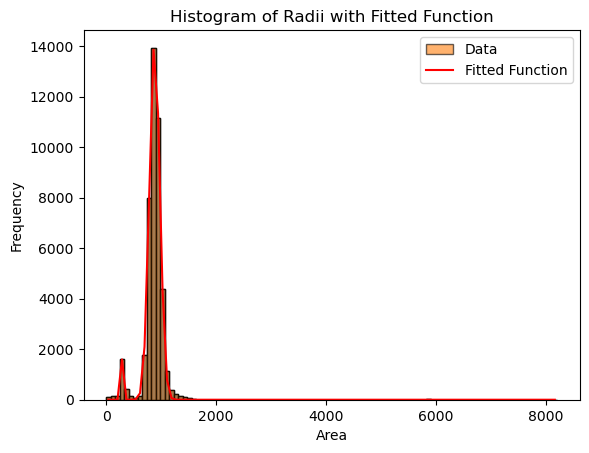

In [5]:
combined_radii=np.array(combined_radii)

combined_radii = np.pi*(combined_radii*512)**2 #area

counts, bins, _ = plt.hist(combined_radii, bins=100, edgecolor='k')
bin_centers = (bins[:-1] + bins[1:]) / 2

# 2. Fit the function to the histogram data
popt, pcov = curve_fit(two_gaussians, bin_centers, counts, maxfev=5000,p0=(1200, 400, 50, 400, 750, 150))
print("Fitted parameters:", popt)

# 3. Plot the histogram and overlay the fitted function
plt.hist(combined_radii, bins=100, edgecolor='k', label="Data", alpha=0.6)
plt.plot(bin_centers, two_gaussians(bin_centers, *popt), color="red", label="Fitted Function")

plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Radii with Fitted Function')
plt.legend()
plt.show()
# radius =  map_value_linear(value, 0.003, 0.45, 2, 8)

In [6]:
filepath = './'+str(1)+'_GT'+'/'+'pos_GT.txt'
cell_id = 7  # replace with your desired cell ID
plot_radius_over_time(filepath, cell_id)


FileNotFoundError: [Errno 2] No such file or directory: './1_GT/pos_GT.txt'

In [ ]:
x=0.034
c=0.03366667
b=[0.03366667,0.034,0.03466667]

print(x in b or c in b)

print(np.arange(1,4))

In [ ]:
run=3
xl,yl,rl= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2), unpack=True)

x1=[]
y1=[]
x2_t=[]
y2_t=[]
x2=[]
y2=[]
x3=[]
y3=[]

for i in range(len(xl)):
    if i % 3 == 0:
        x1.append(xl[i])
        y1.append(yl[i])
        
    else:
        x2_t.append(xl[i])
        y2_t.append(yl[i])
        
for i in range(len(x2_t)):
    
    if i % 2 == 0:
        x2.append(x2_t[i])
        y2.append(y2_t[i])
        
    else:
        x3.append(x2_t[i])
        y3.append(y2_t[i])
        
        



plt.plot(x1,y1,c='red')
plt.plot(x2,y2,c='blue')
plt.plot(x3,y3,c='green')
plt.show()